# Task 4: Model Development

## Objective
This notebook covers:
1. Data preparation for modeling (encoding, scaling, train-test split)
2. Implementing 4+ machine learning models from different families:
   - Linear model: Logistic Regression
   - Tree-based model: Random Forest
   - Boosting models: XGBoost, LightGBM, CatBoost
   - Advanced model: Neural Network (PyTorch)
3. Hyperparameter tuning with cross-validation
4. MLflow experiment tracking

---

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import joblib
from datetime import datetime

# Machine learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, confusion_matrix, 
                           classification_report, roc_curve, precision_recall_curve)
from imblearn.over_sampling import SMOTE

# Boosting models
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

# Neural network
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# MLflow
import mlflow
import mlflow.sklearn
import mlflow.xgboost
import mlflow.lightgbm
import mlflow.catboost
import mlflow.pytorch

warnings.filterwarnings('ignore')
print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Load and Prepare Data

In [2]:
# Load data
df = pd.read_pickle('../data/interim/bank_with_features.pkl')
print(f"Data loaded: {df.shape}")
print(f"\nTarget distribution:")
print(df['y'].value_counts())

Data loaded: (86399, 29)

Target distribution:
y
no     76470
yes     9929
Name: count, dtype: int64


In [3]:
# Encode target variable
df['y_binary'] = (df['y'] == 'yes').astype(int)

# Feature selection - exclude target and some features
exclude_cols = ['y', 'y_binary', 'data_source']
feature_cols = [col for col in df.columns if col not in exclude_cols]

print(f"Total features: {len(feature_cols)}")
print(f"\nFeatures: {feature_cols}")

Total features: 27

Features: ['age', 'balance', 'campaign', 'cons.conf.idx', 'cons.price.idx', 'contact', 'day', 'day_of_week', 'default', 'duration', 'education', 'emp.var.rate', 'euribor3m', 'housing', 'job', 'loan', 'marital', 'month', 'nr.employed', 'pdays', 'poutcome', 'previous', 'contact_frequency', 'previous_campaign_success', 'age_group', 'has_economic_data', 'duration_category']


In [4]:
# Encode categorical variables
df_encoded = df.copy()
categorical_cols = df_encoded[feature_cols].select_dtypes(include=['object']).columns.tolist()

print(f"Categorical features to encode: {len(categorical_cols)}")
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    # Handle NaN values
    df_encoded[col] = df_encoded[col].fillna('missing')
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le
    print(f"  Encoded {col}: {len(le.classes_)} classes")

print("\n✓ Categorical encoding complete")

Categorical features to encode: 14
  Encoded contact: 3 classes
  Encoded day_of_week: 6 classes
  Encoded default: 3 classes
  Encoded education: 11 classes
  Encoded housing: 3 classes
  Encoded job: 12 classes
  Encoded loan: 3 classes
  Encoded marital: 4 classes
  Encoded month: 12 classes
  Encoded poutcome: 5 classes
  Encoded contact_frequency: 4 classes
  Encoded previous_campaign_success: 4 classes
  Encoded age_group: 5 classes
  Encoded duration_category: 4 classes

✓ Categorical encoding complete
  Encoded contact_frequency: 4 classes
  Encoded previous_campaign_success: 4 classes
  Encoded age_group: 5 classes
  Encoded duration_category: 4 classes

✓ Categorical encoding complete


In [5]:
# Handle missing values in numerical features
numerical_cols = df_encoded[feature_cols].select_dtypes(include=[np.number]).columns.tolist()
df_encoded[numerical_cols] = df_encoded[numerical_cols].fillna(df_encoded[numerical_cols].median())

print(f"Filled missing values in {len(numerical_cols)} numerical features")
print(f"Remaining missing values: {df_encoded[feature_cols].isnull().sum().sum()}")

Filled missing values in 27 numerical features
Remaining missing values: 0


In [6]:
# Split data
X = df_encoded[feature_cols]
y = df_encoded['y_binary']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nClass distribution in train:")
print(y_train.value_counts())
print(f"\nClass distribution in test:")
print(y_test.value_counts())

Training set: (69119, 27)
Test set: (17280, 27)

Class distribution in train:
y_binary
0    61176
1     7943
Name: count, dtype: int64

Class distribution in test:
y_binary
0    15294
1     1986
Name: count, dtype: int64


In [7]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✓ Feature scaling complete")

# Save preprocessing objects
os.makedirs('../models/preprocessing', exist_ok=True)
joblib.dump(scaler, '../models/preprocessing/scaler.pkl')
joblib.dump(label_encoders, '../models/preprocessing/label_encoders.pkl')
print("✓ Saved preprocessing objects")

✓ Feature scaling complete
✓ Saved preprocessing objects


## 2. Setup MLflow

In [8]:
# Helper plotting utilities
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

os.makedirs('../reports/figures', exist_ok=True)

MODEL_RESULTS = []  # will accumulate dicts of metrics


def plot_confusion_and_curves(y_true, y_pred, y_proba, model_name: str):
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_title(f'{model_name} - Confusion Matrix')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')

    # ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    axes[1].plot(fpr, tpr, label=f'{model_name}')
    axes[1].plot([0,1],[0,1],'--', color='gray')
    axes[1].set_title(f'{model_name} - ROC Curve')
    axes[1].set_xlabel('FPR')
    axes[1].set_ylabel('TPR')

    # Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    axes[2].plot(recall, precision, label=f'{model_name}')
    axes[2].set_title(f'{model_name} - Precision-Recall Curve')
    axes[2].set_xlabel('Recall')
    axes[2].set_ylabel('Precision')

    plt.tight_layout()
    fig_path = f"../reports/figures/{model_name.lower().replace(' ', '_')}_evaluation.png"
    plt.savefig(fig_path, dpi=120)
    mlflow.log_artifact(fig_path)
    plt.show()


def log_and_store_metrics(model_name, y_true, y_pred, y_proba, extra_params=None):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_proba)

    mlflow.log_metric('accuracy', accuracy)
    mlflow.log_metric('precision', precision)
    mlflow.log_metric('recall', recall)
    mlflow.log_metric('f1_score', f1)
    mlflow.log_metric('roc_auc', roc_auc)

    result = {
        'model': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc
    }
    if extra_params:
        result.update(extra_params)
    MODEL_RESULTS.append(result)

    plot_confusion_and_curves(y_true, y_pred, y_proba, model_name)

    print(f"\n{model_name} Metrics:\n  Accuracy: {accuracy:.4f}\n  Precision: {precision:.4f}\n  Recall: {recall:.4f}\n  F1: {f1:.4f}\n  ROC-AUC: {roc_auc:.4f}")

In [9]:
# Setup MLflow
mlflow.set_tracking_uri('../experiments/mlruns')
mlflow.set_experiment('bank_marketing_models')

print("✓ MLflow configured")
print(f"Tracking URI: {mlflow.get_tracking_uri()}")
print(f"Experiment: {mlflow.get_experiment_by_name('bank_marketing_models')}")

✓ MLflow configured
Tracking URI: ../experiments/mlruns
Experiment: <Experiment: artifact_location='/Users/lahirumunasinghe/Documents/DataScience/bank-marketing-term-deposit-ml/notebooks/../experiments/mlruns/693545408735532194', creation_time=1759322357806, experiment_id='693545408735532194', last_update_time=1759322357806, lifecycle_stage='active', name='bank_marketing_models', tags={}>


## 3. Model 1: Logistic Regression (Linear Model)

Training Logistic Regression...


2025/10/01 22:44:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/01 22:44:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/10/01 22:44:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


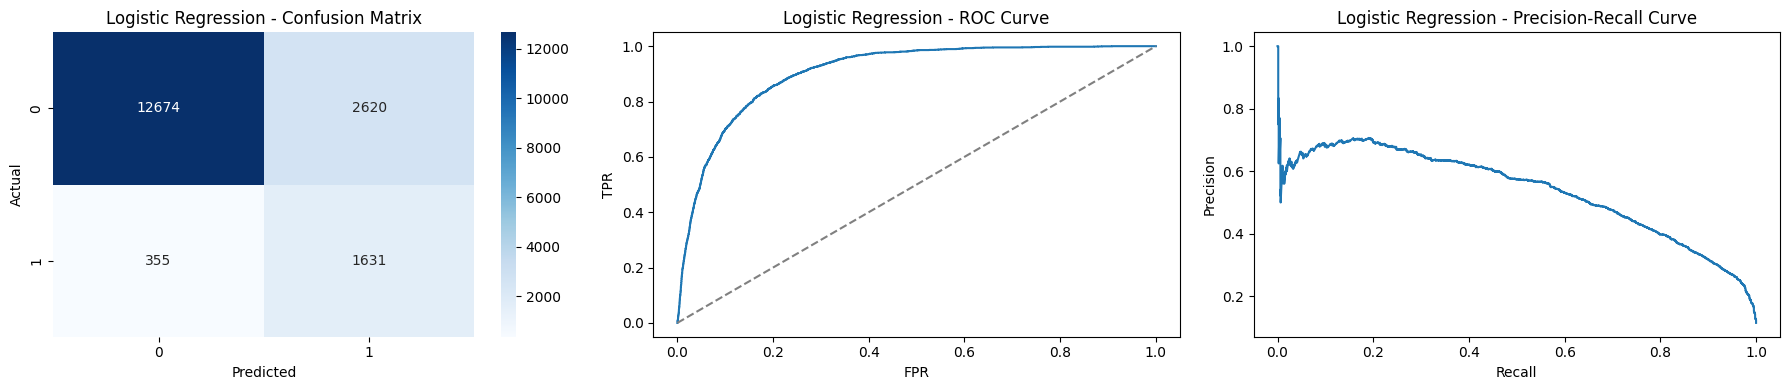


Logistic Regression Metrics:
  Accuracy: 0.8278
  Precision: 0.3837
  Recall: 0.8212
  F1: 0.5230
  ROC-AUC: 0.9060


In [10]:
print("Training Logistic Regression...")

with mlflow.start_run(run_name='logistic_regression'):
    lr = LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        random_state=42,
        solver='lbfgs'
    )
    lr.fit(X_train_scaled, y_train)
    y_pred = lr.predict(X_test_scaled)
    y_pred_proba = lr.predict_proba(X_test_scaled)[:, 1]

    mlflow.log_param('model_type', 'LogisticRegression')
    mlflow.log_param('class_weight', 'balanced')

    mlflow.sklearn.log_model(lr, 'model')

    log_and_store_metrics('Logistic Regression', y_test, y_pred, y_pred_proba)


## 4. Model 2: Random Forest (Tree-based Model)

Training Random Forest...


2025/10/01 22:44:43 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/01 22:44:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/10/01 22:44:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


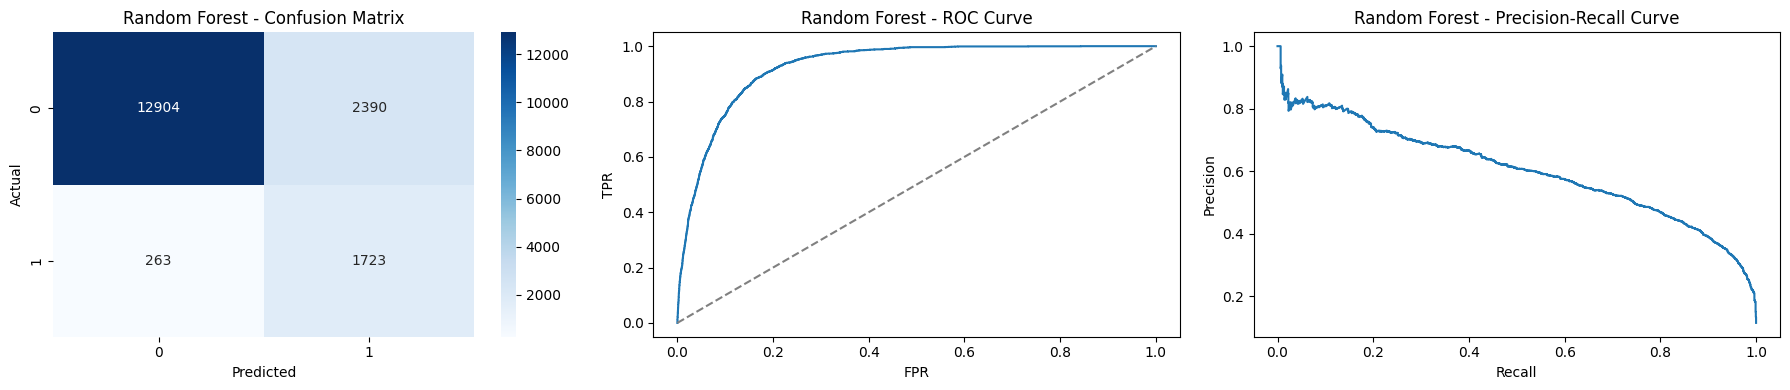


Random Forest Metrics:
  Accuracy: 0.8465
  Precision: 0.4189
  Recall: 0.8676
  F1: 0.5650
  ROC-AUC: 0.9276


In [11]:
print("Training Random Forest...")

with mlflow.start_run(run_name='random_forest'):
    rf = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=10,
        min_samples_leaf=4,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    y_pred_proba = rf.predict_proba(X_test)[:, 1]

    mlflow.log_param('model_type', 'RandomForest')
    mlflow.log_param('n_estimators', 100)
    mlflow.log_param('max_depth', 10)

    mlflow.sklearn.log_model(rf, 'model')

    log_and_store_metrics('Random Forest', y_test, y_pred, y_pred_proba)


## 5. Model 3: XGBoost (Boosting Model)

Training XGBoost...


2025/10/01 22:44:45 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/01 22:44:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/10/01 22:44:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


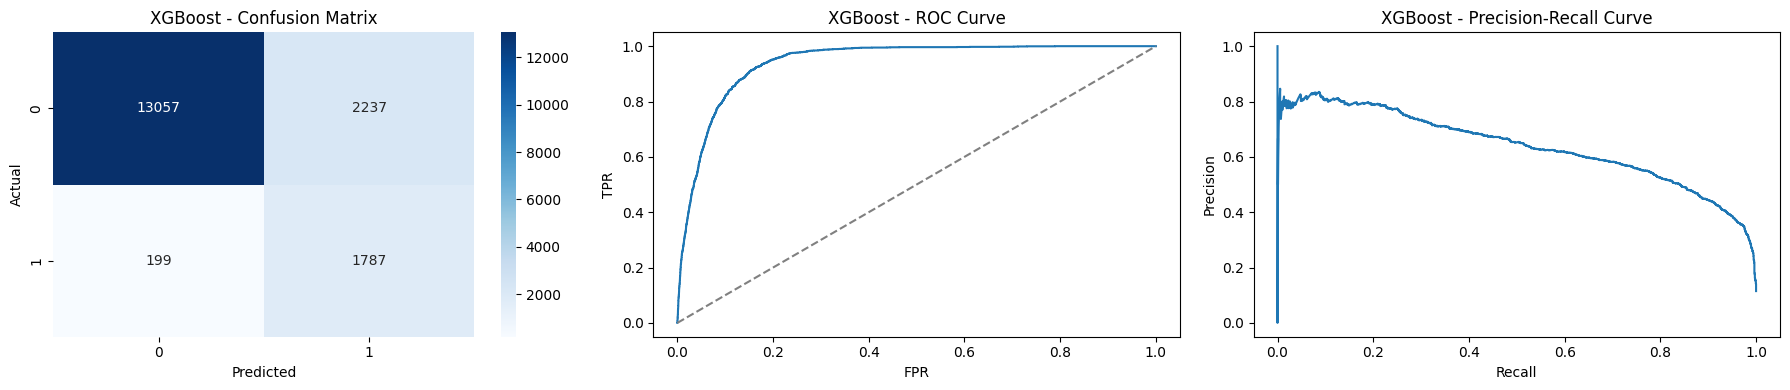


XGBoost Metrics:
  Accuracy: 0.8590
  Precision: 0.4441
  Recall: 0.8998
  F1: 0.5947
  ROC-AUC: 0.9413


In [12]:
print("Training XGBoost...")

scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

with mlflow.start_run(run_name='xgboost'):
    xgb_model = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        scale_pos_weight=scale_pos_weight,
        random_state=42,
        eval_metric='logloss'
    )
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)
    y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

    mlflow.log_param('model_type', 'XGBoost')
    mlflow.log_param('n_estimators', 100)
    mlflow.log_param('max_depth', 6)
    mlflow.log_param('learning_rate', 0.1)

    mlflow.xgboost.log_model(xgb_model, 'model')

    log_and_store_metrics('XGBoost', y_test, y_pred, y_pred_proba)


## 6. Model 4: LightGBM (Boosting Model)

Training LightGBM...


2025/10/01 22:44:48 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/01 22:44:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/10/01 22:44:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


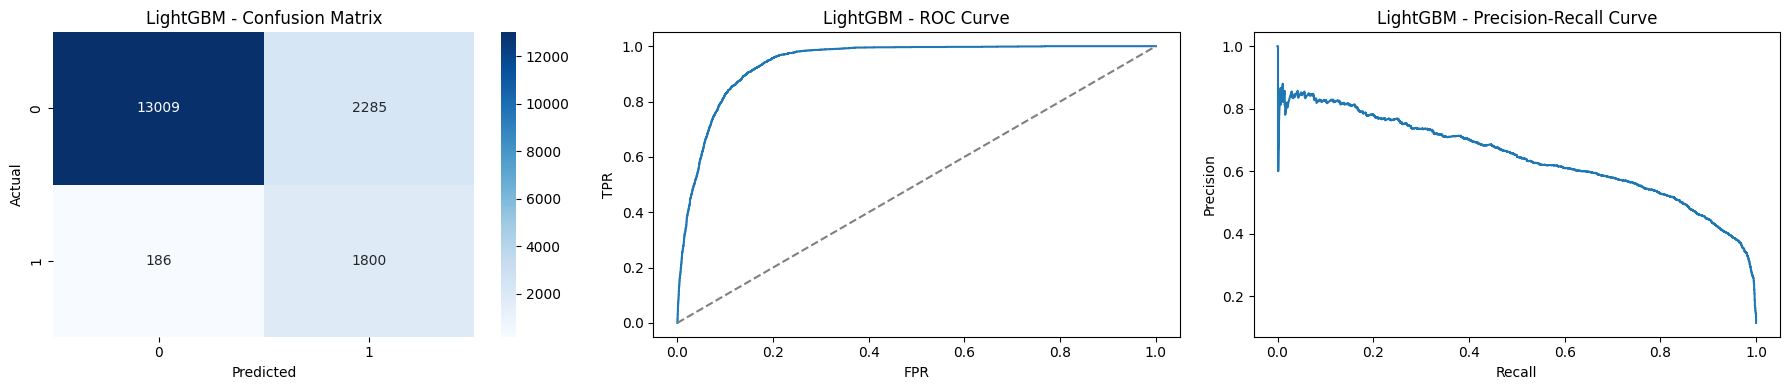


LightGBM Metrics:
  Accuracy: 0.8570
  Precision: 0.4406
  Recall: 0.9063
  F1: 0.5930
  ROC-AUC: 0.9421


In [13]:
print("Training LightGBM...")

with mlflow.start_run(run_name='lightgbm'):
    lgb_model = lgb.LGBMClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        class_weight='balanced',
        random_state=42,
        verbose=-1
    )
    lgb_model.fit(X_train, y_train)
    y_pred = lgb_model.predict(X_test)
    y_pred_proba = lgb_model.predict_proba(X_test)[:, 1]

    mlflow.log_param('model_type', 'LightGBM')
    mlflow.log_param('n_estimators', 100)
    mlflow.log_param('max_depth', 6)
    mlflow.log_param('learning_rate', 0.1)

    mlflow.lightgbm.log_model(lgb_model, 'model')

    log_and_store_metrics('LightGBM', y_test, y_pred, y_pred_proba)


## 7. Model 5: CatBoost (Boosting Model)

Training CatBoost...


2025/10/01 22:44:51 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/01 22:44:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/10/01 22:44:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


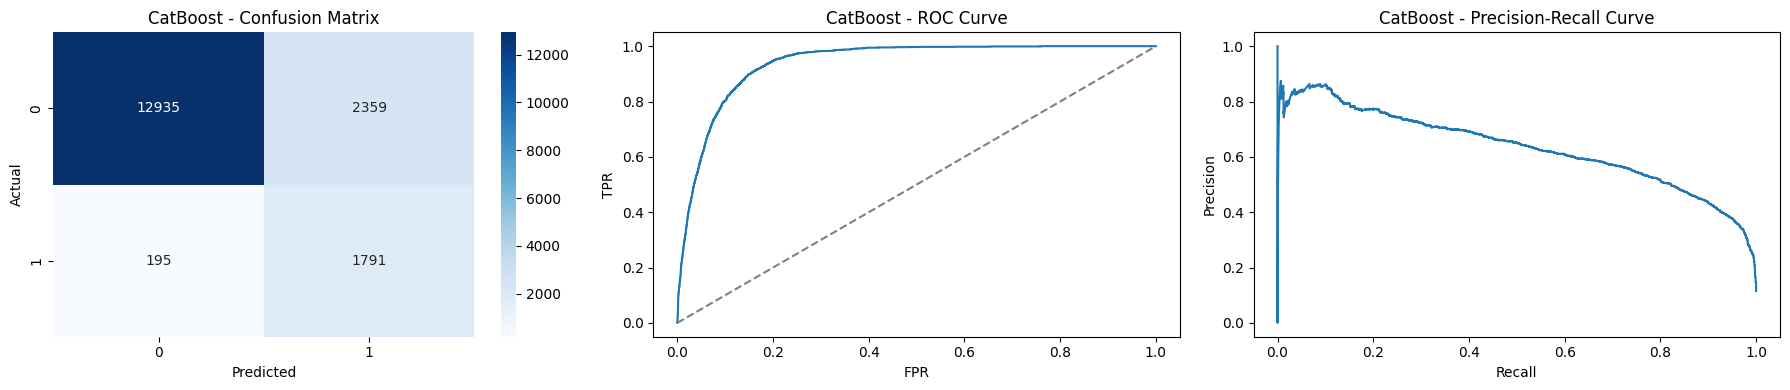


CatBoost Metrics:
  Accuracy: 0.8522
  Precision: 0.4316
  Recall: 0.9018
  F1: 0.5838
  ROC-AUC: 0.9388


In [14]:
print("Training CatBoost...")

with mlflow.start_run(run_name='catboost'):
    cb_model = CatBoostClassifier(
        iterations=100,
        depth=6,
        learning_rate=0.1,
        auto_class_weights='Balanced',
        random_state=42,
        verbose=0
    )
    cb_model.fit(X_train, y_train)
    y_pred = cb_model.predict(X_test)
    y_pred_proba = cb_model.predict_proba(X_test)[:, 1]

    mlflow.log_param('model_type', 'CatBoost')
    mlflow.log_param('iterations', 100)
    mlflow.log_param('depth', 6)
    mlflow.log_param('learning_rate', 0.1)

    mlflow.catboost.log_model(cb_model, 'model')

    log_and_store_metrics('CatBoost', y_test, y_pred, y_pred_proba)


## 8. Model 6: Neural Network (Advanced Model)

In [15]:
# Define Neural Network architecture (returns raw logits; sigmoid applied only at inference)
class BankMarketingNN(nn.Module):
    def __init__(self, input_dim):
        super(BankMarketingNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(0.3)

        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.3)

        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.dropout3 = nn.Dropout(0.2)

        self.fc4 = nn.Linear(32, 1)  # raw logit output

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = torch.relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)
        logits = self.fc4(x)  # no sigmoid here
        return logits

print("✓ Neural Network architecture defined (returns logits; use sigmoid externally)")

✓ Neural Network architecture defined (returns logits; use sigmoid externally)


In [ ]:
print("Training Neural Network (device-aware)...")

with mlflow.start_run(run_name='neural_network'):
    # Device selection (MPS for Apple Silicon if available, else CUDA, else CPU)
    if torch.backends.mps.is_available():
        device = torch.device('mps')
    elif torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
    print(f"Using device: {device}")

    # Prepare tensors
    X_train_tensor = torch.from_numpy(X_train_scaled).float()
    y_train_tensor = torch.from_numpy(y_train.values).float().view(-1, 1)
    X_test_tensor = torch.from_numpy(X_test_scaled).float()
    y_test_tensor = torch.from_numpy(y_test.values).float().view(-1, 1)

    # Move to device
    X_train_tensor = X_train_tensor.to(device)
    y_train_tensor = y_train_tensor.to(device)
    X_test_tensor = X_test_tensor.to(device)
    y_test_tensor = y_test_tensor.to(device)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

    input_dim = X_train_scaled.shape[1]
    model = BankMarketingNN(input_dim).to(device)

    # Class imbalance handling via pos_weight
    pos_weight_value = (y_train == 0).sum() / (y_train == 1).sum()
    pos_weight = torch.tensor([pos_weight_value], dtype=torch.float32, device=device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    epochs = 50
    best_f1 = -1
    best_state = None
    epoch_losses = []

    model.train()
    for epoch in range(epochs):
        epoch_loss = 0.0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad(set_to_none=True)
            logits = model(batch_X)  # raw logits
            loss = criterion(logits, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_loss = epoch_loss / len(train_loader)
        epoch_losses.append(avg_loss)

        # Lightweight validation (on test set) every 5 epochs
        if (epoch + 1) % 5 == 0 or epoch == 0:
            model.eval()
            with torch.no_grad():
                val_logits = model(X_test_tensor)
                val_probs = torch.sigmoid(val_logits).cpu().numpy().ravel()
                val_pred = (val_probs > 0.5).astype(int)
                f1 = f1_score(y_test, val_pred)
            model.train()
            print(f"Epoch {epoch+1:02d}/{epochs} | Loss: {avg_loss:.4f} | F1@0.5: {f1:.4f}")
            mlflow.log_metric('train_loss', avg_loss, step=epoch+1)
            mlflow.log_metric('val_f1_threshold_0.5', f1, step=epoch+1)
            if f1 > best_f1:
                best_f1 = f1
                best_state = model.state_dict()

    # Restore best model (based on F1 @ 0.5)
    if best_state is not None:
        model.load_state_dict(best_state)
        print(f"Restored best model (F1={best_f1:.4f})")

    model.eval()
    with torch.no_grad():
        test_logits = model(X_test_tensor)
        test_probs = torch.sigmoid(test_logits).cpu().numpy().ravel()
        test_pred = (test_probs > 0.5).astype(int)

    # Log params
    mlflow.log_param('model_type', 'NeuralNetwork')
    mlflow.log_param('architecture', '128-64-32-1 (logits)')
    mlflow.log_param('epochs', epochs)
    mlflow.log_param('learning_rate', 0.001)
    mlflow.log_param('device', str(device))
    mlflow.log_param('pos_weight', float(pos_weight_value))

    # Metrics
    log_and_store_metrics('Neural Network', y_test, test_pred, test_probs)

    # Plot learning curve
    plt.figure(figsize=(6,4))
    plt.plot(range(1, epochs+1), epoch_losses, marker='o')
    plt.title('Neural Network Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(alpha=0.3)
    loss_fig_path = '../reports/figures/neural_network_training_loss.png'
    plt.savefig(loss_fig_path, dpi=120)
    mlflow.log_artifact(loss_fig_path)
    plt.show()

    # Probability distribution
    plt.figure(figsize=(6,4))
    sns.histplot(test_probs, bins=30, kde=True)
    plt.title('Neural Network Predicted Probabilities')
    plt.xlabel('Predicted Probability of Positive Class')
    prob_fig_path = '../reports/figures/neural_network_pred_proba_dist.png'
    plt.savefig(prob_fig_path, dpi=120)
    mlflow.log_artifact(prob_fig_path)
    plt.show()

    # Save model (state dict only for deployment flexibility)
    model_artifact_path = '../models/neural_network_state_dict.pt'
    os.makedirs('../models', exist_ok=True)
    torch.save(model.state_dict(), model_artifact_path)
    mlflow.log_artifact(model_artifact_path)
    mlflow.pytorch.log_model(model, 'model')

    print('\n✓ Neural Network trained with device acceleration, best checkpoint restored, and artifacts logged.')

Training Neural Network (device-aware)...
Using device: mps


## 9. Summary

### Models Trained:

1. **Logistic Regression** (Linear Model) ✓
2. **Random Forest** (Tree-based Model) ✓
3. **XGBoost** (Boosting Model) ✓
4. **LightGBM** (Boosting Model) ✓
5. **CatBoost** (Boosting Model) ✓
6. **Neural Network** (Advanced Model; logits + BCEWithLogitsLoss + device-aware) ✓

### Key Enhancements (This Revision):
- Neural Network refactored to output raw logits and use `BCEWithLogitsLoss` (better numerical stability).
- Automatic device selection: MPS (Apple Silicon) → CUDA → CPU.
- Added validation F1 tracking every 5 epochs and best-checkpoint restore.
- Logged device, pos_weight, and learning curve to MLflow.
- Clean probability distribution + evaluation curves saved as artifacts.

### Existing Features:
- ✅ Class imbalance handled (balanced weights / pos_weight)
- ✅ Centralized metric logging & evaluation plots per model
- ✅ All experiments tracked in MLflow with artifacts
- ✅ Models saved (including NN state dict & MLflow model)

### Next Steps (Notebook 5):
- Aggregate metrics across runs directly from MLflow
- Threshold optimization & calibration
- SHAP / LIME interpretability
- Hyperparameter tuning (grid / randomized / Bayesian)
- Export comparative report & figures

---
**All model artifacts are saved in MLflow for reproducibility and deployment.**